In [1]:
from fipy import Grid3D, Grid2D, CellVariable, Viewer, numerix
from fipy import DiffusionTerm, ExplicitDiffusionTerm, TransientTerm, ImplicitDiffusionTerm

import numpy as np

from parameters import *
from plotting_utils import *
from parameterfunctions import *

In [2]:
mesh = Grid3D(nx = N_x, ny = N_y, nz = N_z, dx = dx, dy = dy, dz = dz)

x = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[0])
y = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[1])
z = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[2])

temperature = CellVariable(mesh = mesh, name = 'temperature', value=300.0)
pressure = CellVariable(mesh = mesh, name = 'pressure')
v_x = CellVariable(mesh = mesh, name = 'x-velocity', value=10.0)
v_y = CellVariable(mesh = mesh, name = 'y-velocity', value=0.0)
v_z = CellVariable(mesh = mesh, name = 'z-velocity', value=0.0)
sensible_heat = CellVariable(mesh = mesh, name = 'sensible heat', value=0.0)
latent_heat = CellVariable(mesh = mesh, name = 'latent heat', value=0.0)

velocity = CellVariable(mesh = mesh, name = 'velocity', rank = 1, value = numerix.array([numerix.array(v_x), numerix.array(v_y), numerix.array(v_z)]))

#setting the constraints
sensible_heat.constrain(0.0, mesh.exteriorFaces)

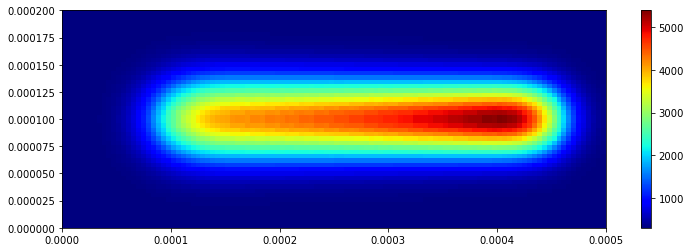

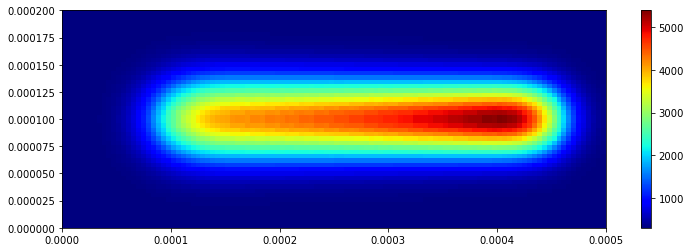

In [133]:
#starting values

x_pos = 0.0001
layer = 1
hatch = 2.5
time = 0.0

N = round(mesh.nz / layers) * layer

source_value = laser_factor*numerix.exp(-distribution_factor*((x-x_pos)**2+(y-hatch*hatch_width)**2)/beam_radius**2)*dt
source = numerix.where(numerix.absolute(z-layer*layer_thickness)<layer_thickness, source_value, 0.0)
source_term = CellVariable(mesh = mesh, name = 'source', value=source)
 
c = get_effective_specific_heat(argon_density, steel_density, packing_efficiency, argon_density, temperature, mesh)
rho = get_effective_density(argon_density, steel_density, packing_efficiency)
k = get_effective_cond(mesh, temperature, packing_efficiency)
liquid = get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)

laser_factor = CellVariable(mesh = mesh, value = ((1-liquid)*steel_powder_absoprtion+liquid*steel_liquid_absoprtion)*distribution_factor*laser_power/(numerix.pi*beam_radius**2*layer_thickness))

alpha = k/(rho*c)

sensible_heat = CellVariable(mesh = mesh, name = 'sensible heat', value=0.0)
konv_diff_eq = TransientTerm(var = sensible_heat)  == DiffusionTerm(var = sensible_heat, coeff=alpha) + source_term - liquid*steel_latent_heat*dt

for i in range(time_steps):
    
    print(i)
    print(time)
    
    #setting new source term:
    source_value = laser_factor*numerix.exp(-distribution_factor*((x-x_pos)**2+(y-hatch*hatch_width)**2)/beam_radius**2)*dt
    source = numerix.where(numerix.absolute(z-layer*layer_thickness) < layer_thickness, source_value, 0.0)
    source_term.setValue(source)

    #saving old heat for temperature change:
    heat_old = numerix.array(sensible_heat) 
    
    #finite-volume solving:
    res = konv_diff_eq.sweep(dt = dt)

    #update material paramters:
    c = (1-liquid)*get_effective_specific_heat(argon_density, steel_density, packing_efficiency, argon_density, temperature, mesh) + liquid*steel_fluid_c
    k = get_effective_cond(mesh, temperature, packing_efficiency)
    alpha = k/(rho*c)
    liquid = get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)
    
    #calculate temperature change and add:
    temperature.setValue(numerix.array(temperature) + 1/c*(sensible_heat-heat_old)) 

    #2d-plot
    plot_2d_xy(temperature, N)
    
    x_pos +=dt*scanning_speed
    time += dt
    
    if x_pos >= L_x:
        
        hatch += 1
        x_pos = 0.0
        
        if hatch == hatches:
            
            layer += 1
            hatch = 0
            
            if layer == layers:
                
                break

In [ ]:
print(time)
N = 13
np.array(temperature[N*55:(N+1)*55])

In [8]:
liquid = get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)

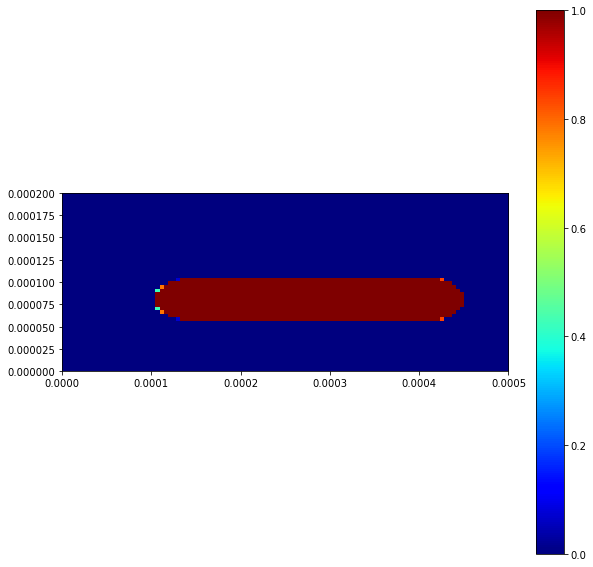

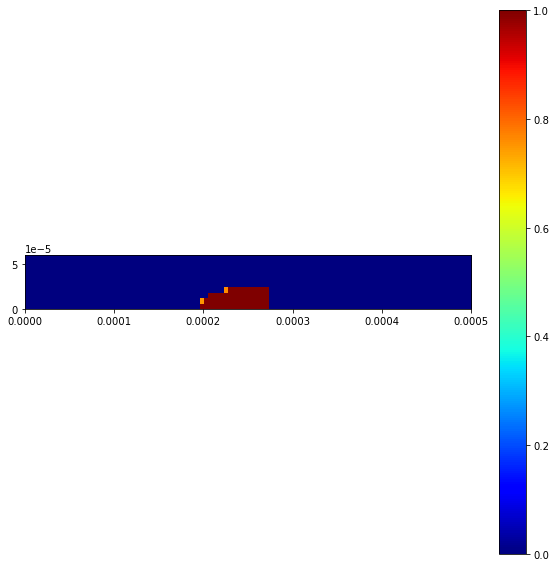

In [123]:
plot_2d_xy(liquid, 0)
plot_2d_xz(liquid, mesh.ny-1)

In [61]:
np.array(c[N*55:(N+1)*55])

array([4.82664164e+02, 5.57430635e+02, 7.58772627e+02, 1.02443492e+05,
       9.03361729e+06, 3.62679400e+08, 7.64551023e+09, 8.70334908e+10,
       5.38507511e+11, 1.81420254e+12, 3.32964988e+12, 3.32964988e+12,
       1.81420254e+12, 5.38507513e+11, 8.70334937e+10, 7.64551444e+09,
       3.62685348e+08, 9.04200931e+06, 1.15399610e+05, 4.83399624e+05,
       6.16690557e+03, 5.92017348e+02, 5.11972554e+02, 4.72317058e+02,
       4.66704052e+02, 4.66134670e+02, 4.66088284e+02, 4.66085206e+02,
       4.66085039e+02, 4.66085032e+02, 4.66085032e+02, 4.66085032e+02,
       4.66085032e+02, 4.66085032e+02, 4.66085032e+02, 4.66085032e+02,
       4.66085032e+02, 4.66085032e+02, 4.66085032e+02, 4.66085032e+02,
       4.66085032e+02, 4.66085032e+02, 4.66085032e+02, 4.66085032e+02,
       4.66085032e+02, 4.66085032e+02, 4.66085032e+02, 4.66085032e+02,
       4.66085032e+02, 4.66085032e+02, 4.66085032e+02, 4.66085032e+02,
       4.66085032e+02, 4.66085032e+02, 4.66085032e+02])

In [39]:
laser_factor

584650811357982.9

In [40]:
x = 0*dt*scanning_speed
y = 0
laser_factor*numerix.exp(-distribution_factor*((x)**2+(y)**2)/beam_radius**2)

584650811357982.9

In [42]:
dt*scanning_speed

1.3999999999999998e-05

In [41]:
12*dt*scanning_speed

0.00016799999999999996

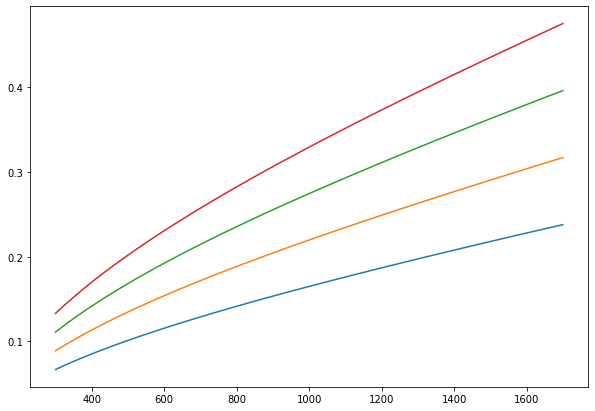

In [70]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(300, 1700)
plt.figure(figsize = (10, 7))
for p in [0.3, 0.4, 0.5, 0.6]:
    thermal_conductivity_gas = -0.1125/np.sqrt(t) + 1.35e-3*np.sqrt(t)+1.453e-7*t**(1.5)
    N = 12.0
    particle_diameter = 40e-6
    L = 5.4E-4/particle_diameter
    
    k = thermal_conductivity_gas*0.5*p* N *(0.5*np.log(1+L)+np.log(1+np.sqrt(L)) +1/(1+np.sqrt(L))-1)
    plt.plot(t, k)

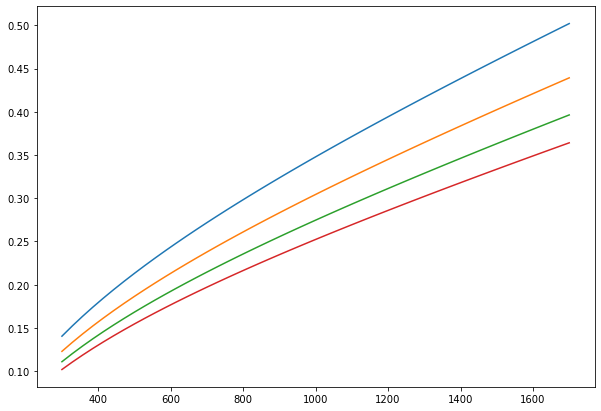

In [71]:
plt.figure(figsize = (10, 7))
for d in [20e-6, 30e-6, 40e-6, 50e-6]:
    thermal_conductivity_gas = -0.1125/np.sqrt(t) + 1.35e-3*np.sqrt(t)+1.453e-7*t**(1.5)
    N = 12.0
    L = 5.4E-4/d
    
    k = thermal_conductivity_gas*0.5*0.5* N *(0.5*np.log(1+L)+np.log(1+np.sqrt(L)) +1/(1+np.sqrt(L))-1)
    plt.plot(t, k)

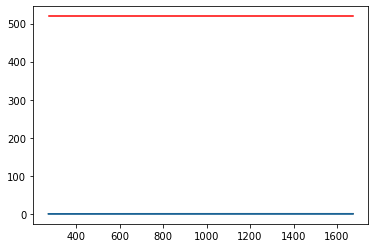

In [18]:
t = np.linspace(273, 1673)
specific_heat = 330.9+0.563*t-4.015e-4*t**2+9.465e-8*t**3

density = get_effective_density(argon_density, steel_density, packing_efficiency)
eff_specific_heat =  (steel_density*0.1*specific_heat + argon_density*(1-packing_efficiency)*argon_density)/density

plt.plot(t, specific_heat/1000, 'k-')
plt.plot(t, eff_specific_heat/1000)
plt.plot(t, [argon_c]*len(t), 'r-')
#plt.ylim(0.45, 0.85)

In [118]:
np.array(alpha)

array([6.09516860e-08, 6.10973661e-08, 6.19308153e-08, ...,
       6.09271030e-08, 6.09271030e-08, 6.09271030e-08])

In [13]:
density

4680.3896

In [19]:
steel_density

7800.0

In [20]:
argon_density

0.974

In [25]:
get_effective_density(argon_density, steel_density, 0)

0.974

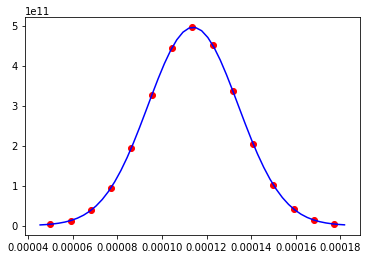

In [72]:
N1 = 5
N2 = 20
x_range = np.linspace(N1*dx, N2*dx)
plt.plot(np.array(x[N1:N2]), source[N1:N2], 'ro')
function = laser_factor*np.exp(-distribution_factor*((x_range-x_pos)**2+(dy/2-hatch*hatch_width)**2)/beam_radius**2)
plt.plot(x_range, function, 'b-')
#plt.plot()

In [68]:
hatch

2

In [54]:
np.diff(np.array(x))

array([2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06, 2.78293135e-06, 2.78293135e-06, 2.78293135e-06,
       2.78293135e-06])

In [36]:
hatch*hatch_width

8e-05

In [43]:
x

CellVariable(value=array([4.54545455e-06, 1.36363636e-05, 2.27272727e-05, ...,
       4.77272727e-04, 4.86363636e-04, 4.95454545e-04]), mesh=UniformGrid3D(dx=9.090909090909091e-06, nx=55, dy=8e-06, ny=25, dz=3e-06, nz=20))

In [78]:
dt

6.999999999999999e-06

In [25]:
np.array(k)

array([0.13294091, 0.13294858, 0.13297703, ..., 0.13293767, 0.13293767,
       0.13293767])

In [66]:
dt

1.4e-06

In [98]:
data = numerix.array(temperature)[N*xy_points:(N+1)*xy_points].reshape((mesh.ny, mesh.nx)).transpose()

(1693.0, 3093.0)

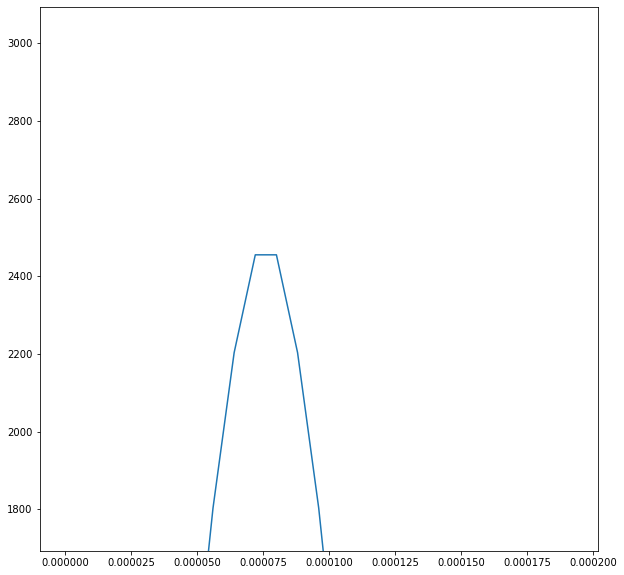

In [116]:
plt.figure(figsize = (10, 10))
plt.plot([i*mesh.dy for i in range(len(data[0]))], data[52])
plt.ylim([1693, 3093])